# _Whew... That Was Close_ by Raquel Haddad

### Import Libraries

In [69]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import urljoin

## Data Collection

### Collect data from NASA's JPL Small Body Database Close-Approach API

In [70]:
# Include diameter data in the query search
url = 'https://ssd-api.jpl.nasa.gov/cad.api'
parameters = {'diameter': 'true'}
response = requests.get(url, params = parameters)
if response.status_code == 200:
    api_data = response.json()
    asteroid_data = api_data['data']
else:
    print('Failed to receive data from the API')

In [89]:
# Fetch data for each Small-Body ID
data_list = []
# Define a list of Small-Body IDs for comparison
small_body_ids = ['1999 RQ36', '29075', '2023 TL4', '2007 FT3', '1979 XB', '99942']
for small_body_id in small_body_ids:
    api_url = f'https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={small_body_id}'
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        data_list.append(data)
    else:
        print(f'Error fetching data for {small_body_id} from the API.')

In [72]:
# Define a function to retrieve orbital elements
def get_orbital_elements(small_body_id):
    api_url = f'https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={small_body_id}'
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        if 'orbit' in data and 'elements' in data['orbit']:
            elements = {elem['name']: float(elem['value']) for elem in data['orbit']['elements']}
            return elements
        else:
            print(f'No orbital elements found for {small_body_id}.')
    else:
        print(f'Error fetching data for {small_body_id} from the API.')
    return None

### Collect data by web scraping "nasa asteroid" Google News articles

In [73]:
url = 'https://news.google.com/search?q=nasa%20asteroid&hl=en-US&gl=US&ceid=US%3Aen'
base_url = 'https://news.google.com/'
r = requests.get(url)
if not r.ok:
    raise Exception('Error accessing the URL')
soup = BeautifulSoup(r.text, 'html.parser')
articles = soup.find_all('article')

## Data Cleaning

In [74]:
# Convert the list to a dataframe
asteroid_dataframe = pd.DataFrame(asteroid_data)
# Convert absolute magnitude column from string to numeric
asteroid_dataframe[10] = pd.to_numeric(asteroid_dataframe[10], errors='coerce')
# Convert distance (au) column from string to numeric
asteroid_dataframe[4] = pd.to_numeric(asteroid_dataframe[4], errors = 'coerce')
# Convert relative velocity column (km/s) from string to numeric
asteroid_dataframe[7] = pd.to_numeric(asteroid_dataframe[7], errors = 'coerce')
# Convert diameter column from string to numeric
asteroid_dataframe[11] = pd.to_numeric(asteroid_dataframe[11], errors = 'coerce')

In [75]:
# Clean HTML tags and convert data to a dictionary
newslist = []
for item in articles:
    newsitem = item.find('h4')
    if newsitem:
        link_relative = item.find('a')['href']
        link_absolute = urljoin(base_url, link_relative)
        newsarticle = {
        'title': newsitem.text,
        'link': link_absolute,
        'date': item.find('time').text
        }
        newslist.append(newsarticle)

## Data Analysis

In [76]:
# Generate descriptive statistics for absolute magnitude
mean = round(asteroid_dataframe[10].mean(), 2)
median = round(asteroid_dataframe[10].median(), 2)
mode = round(asteroid_dataframe[10].mode().iloc[0], 2)
range_val = round(asteroid_dataframe[10].max() - asteroid_dataframe[10].min(), 2)
std_dev = round(asteroid_dataframe[10].std(), 2)
# Print the result
print(f'Mean H: {mean} au, Median H: {median} au, Mode: {mode} au, Range: {range_val}, Standard Deviation: {std_dev}')

Mean H: 25.14 au, Median H: 24.69 au, Mode: 18.47 au, Range: 13.63, Standard Deviation: 2.91


In [77]:
# Generate descriptive statistics for distance
mean = round(asteroid_dataframe[4].mean(), 5)
median = round(asteroid_dataframe[4].median(), 5)
mode = round(asteroid_dataframe[4].mode().iloc[0], 5)
range_val = round(asteroid_dataframe[4].max() - asteroid_dataframe[4].min(), 5)
std_dev = round(asteroid_dataframe[4].std(), 5)
# Print the result
print(f'Mean Distance: {mean} au, Median Distance: {median} au, Mode: {mode} au, Range: {range_val}, Standard Deviation: {std_dev}')

Mean Distance: 0.03023 au, Median Distance: 0.03024 au, Mode: 0.00278 au, Range: 0.04689, Standard Deviation: 0.01391


In [78]:
# Generate descriptive statistics for relative velocity
mean = round(asteroid_dataframe[7].mean(), 2)
median = round(asteroid_dataframe[7].median(), 2)
mode = round(asteroid_dataframe[7].mode().iloc[0], 2)
range_val = round(asteroid_dataframe[7].max() - asteroid_dataframe[7].min(), 2)
std_dev = round(asteroid_dataframe[7].std(), 2)
# Print the result
print(f'Mean Vrel: {mean} km/s, Median Vrel: {median} km/s, Mode: {mode} km/s, Range: {range_val}, Standard Deviation: {std_dev}')

Mean Vrel: 9.32 km/s, Median Vrel: 7.07 km/s, Mode: 1.31 km/s, Range: 22.08, Standard Deviation: 5.33


In [79]:
# Display diameter value, if available
for index, row in asteroid_dataframe.dropna(subset=[11]).iterrows():
    print(f"Asteroid {row[0]} has a diameter of {row[11]}km")

Asteroid 341843 has a diameter of 0.4km


In [80]:
# Initialize lists to store semi-major axis and eccentricity values
semi_major_axes = []
eccentricities = []
# Extract orbital elements and populate the lists
for data, small_body_id in zip(data_list, small_body_ids):
    if 'orbit' in data and 'elements' in data['orbit']:
        orbital_elements = data['orbit']['elements']
        # Extract semi-major axis and eccentricity
        semi_major_axis = next(element['value'] for element in orbital_elements if element['name'] == 'a')
        eccentricity = next(element['value'] for element in orbital_elements if element['name'] == 'e')
        # Append to lists
        semi_major_axes.append(float(semi_major_axis))
        eccentricities.append(float(eccentricity))
# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(semi_major_axes, eccentricities)[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.8027175408551442


In [81]:
# Dictionary with title, link, and date of 10 most recent "nasa asteroid" Google News articles
for i in range(min(10, len(newslist))):
    print(newslist[i])

{'title': 'NASA’s skywatching tips for December include a meteor shower', 'link': 'https://news.google.com/articles/CBMiUWh0dHBzOi8vd3d3LmRpZ2l0YWx0cmVuZHMuY29tL3NwYWNlL25hc2Etc2t5d2F0Y2hpbmctdGlwcy1kZWNlbWJlci1tZXRlb3Itc2hvd2VyL9IBVWh0dHBzOi8vd3d3LmRpZ2l0YWx0cmVuZHMuY29tL3NwYWNlL25hc2Etc2t5d2F0Y2hpbmctdGlwcy1kZWNlbWJlci1tZXRlb3Itc2hvd2VyLz9hbXA?hl=en-US&gl=US&ceid=US%3Aen', 'date': '19 hours ago'}
{'title': '190-foot asteroid to fly past Earth closely today; NASA reveals speed, size and more', 'link': 'https://news.google.com/articles/CBMijwFodHRwczovL3RlY2guaGluZHVzdGFudGltZXMuY29tL3RlY2gvbmV3cy8xOTBmb290LWFzdGVyb2lkLXRvLWZseS1wYXN0LWVhcnRoLWNsb3NlbHktdG9kYXktbmFzYS1yZXZlYWxzLXNwZWVkLXNpemUtYW5kLW1vcmUtNzE3MDE2Njk0MDk3MzcuaHRtbNIBkwFodHRwczovL3RlY2guaGluZHVzdGFudGltZXMuY29tL2FtcC90ZWNoL25ld3MvMTkwZm9vdC1hc3Rlcm9pZC10by1mbHktcGFzdC1lYXJ0aC1jbG9zZWx5LXRvZGF5LW5hc2EtcmV2ZWFscy1zcGVlZC1zaXplLWFuZC1tb3JlLTcxNzAxNjY5NDA5NzM3Lmh0bWw?hl=en-US&gl=US&ceid=US%3Aen', 'date': '14 hours ago'}
{'ti

## Data Visualization

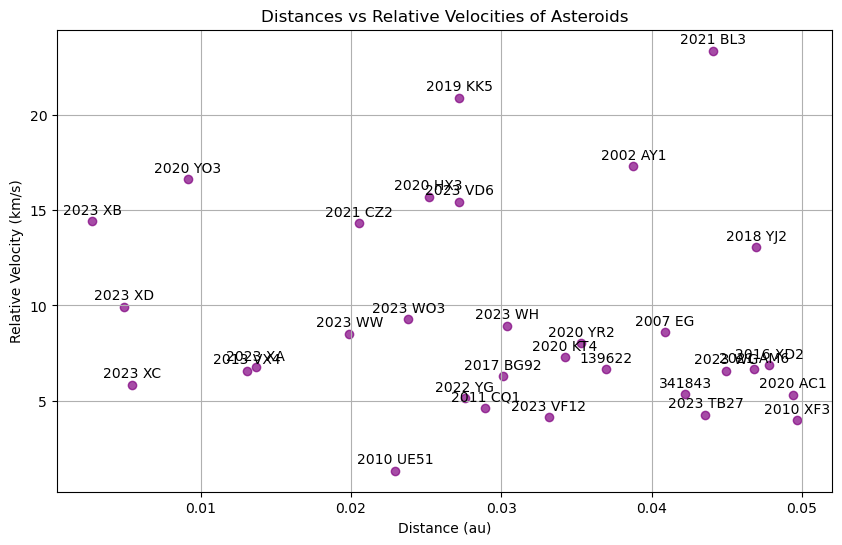

In [82]:
# Illustrate distance vs. relative velocities of asteroids
if response.status_code == 200:
    names = [entry[0] for entry in asteroid_data]
    distances = [float(entry[4]) for entry in asteroid_data]
    relative_velocities = [float(entry[7]) for entry in asteroid_data]
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, relative_velocities, marker='o', color='purple', alpha=0.7)
    # Add labels and title
    plt.title('Distances vs Relative Velocities of Asteroids')
    plt.xlabel('Distance (au)')
    plt.ylabel('Relative Velocity (km/s)')
    # Annotate each point with the celestial body's name
    for i, name in enumerate(names):
        plt.annotate(name, (distances[i], relative_velocities[i]), textcoords="offset points", xytext=(0,5), ha='center')
    # Show the plot
    plt.grid(True)
    plt.show()
else:
    print('Failed to retrieve data from the API')

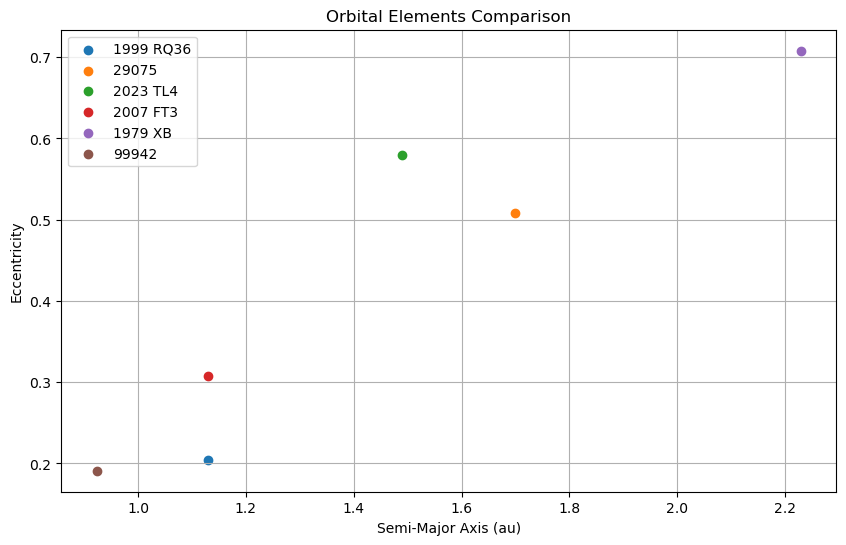

In [90]:
# Plot the orbital elements
plt.figure(figsize=(10, 6))
for data, small_body_id in zip(data_list, small_body_ids):
    if 'orbit' in data and 'elements' in data['orbit']:
        orbital_elements = data['orbit']['elements']
        # Extract semi-major axis and eccentricity
        semi_major_axis = next(element['value'] for element in orbital_elements if element['name'] == 'a')
        eccentricity = next(element['value'] for element in orbital_elements if element['name'] == 'e')
        # Plot on the same axes
        plt.scatter(float(semi_major_axis), float(eccentricity), label=small_body_id)
# Customize the plot
plt.title('Orbital Elements Comparison')
plt.xlabel('Semi-Major Axis (au)')
plt.ylabel('Eccentricity')
plt.legend()
plt.grid(True)
plt.show()

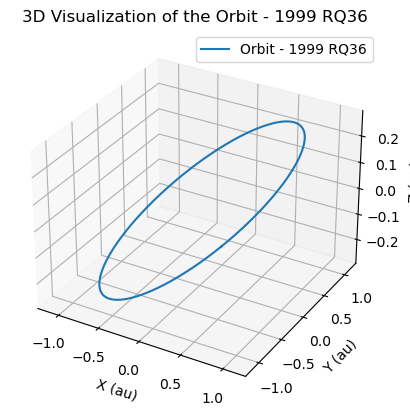

In [86]:
def plot_3d_orbit(small_body_id):
    # Get orbital elements
    elements = get_orbital_elements(small_body_id)
    if elements is not None:
        # Extract orbital elements
        a = elements.get('a', 0)
        e = elements.get('e', 0)
        incl = elements.get('i', 0)
        omega = elements.get('om', 0)
        argp = elements.get('w', 0)
        mean_anomaly = elements.get('ma', 0)
        # Time array
        time = np.linspace(0, 2 * np.pi, 1000)
        # Parametric equations for the orbital position in 3D space
        x = a * (np.cos(omega) * np.cos(argp + time) - np.sin(omega) * np.sin(argp + time) * np.cos(incl))
        y = a * (np.sin(omega) * np.cos(argp + time) + np.cos(omega) * np.sin(argp + time) * np.cos(incl))
        z = a * (np.sin(argp + time) * np.sin(incl))
        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # Plot the orbit
        ax.plot(x, y, z, label=f'Orbit - {small_body_id}')
        # Set labels
        ax.set_xlabel('X (au)')
        ax.set_ylabel('Y (au)')
        ax.set_zlabel('Z (au)')
        ax.set_title(f'3D Visualization of the Orbit - {small_body_id}')
        # Show the plot
        plt.legend()
        plt.show()
# Example usage
small_body_id = "1999 RQ36"
plot_3d_orbit(small_body_id)